#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate
import scipy

In [2]:
import sys
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 16

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]  

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [16]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [17]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [18]:
E = 210e9

In [19]:
E*Ar/1e10

1.6991625880187402

In [20]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [21]:
DT=np.diag(diag_DT) # (35) in [2]

In [22]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [23]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [24]:
CT=np.diag(diag_CT)

In [25]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [26]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [27]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [28]:
rng = np.random.default_rng()

In [29]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [30]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [31]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.31151041, -0.66267237, -0.68104816],
       [ 0.88096335,  0.47004567, -0.05441175],
       [ 0.3561809 , -0.58302864,  0.73021419]])

In [32]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.001054


In [33]:
Ret.shape

(16, 3, 3)

In [34]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [35]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
    return np.array(ans).T

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000149


In [37]:
C1(dx,dy,dz,Ret)

array([[-0.05712138, -0.24843072,  5.45352608,  0.19788307,  0.12421408,
         0.35539168,  0.30987393, -0.04621928, -0.85317788, -0.01472795,
         1.60468157,  6.91519264,  0.14470922, -1.05548151, -0.04622385,
         0.31948066],
       [-3.69493442, -0.20630808,  0.96645929,  3.65304457, -1.63898488,
         0.15024162, -1.36707682,  0.80547507, -0.10643818,  3.80763348,
        -0.35713054,  1.22045539,  0.13428979, -0.37240147, -1.74795101,
        -0.07346671],
       [ 8.50632783,  0.57078983, -1.47871786, -0.23479506,  2.57005961,
        -0.42512391, -2.35713487,  2.09553211,  0.31653128,  2.51921221,
         0.22691775,  0.57620213,  0.35389153, -0.09156556, -3.63090926,
         0.2149392 ]])

In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[  -327.82151466, -21205.35403119,  48818.10412667],
       [ -1425.75230678,  -1184.00909079,   3275.78219884],
       [ 31297.97125529,   5546.54268721,  -8486.41199036],
       [  1135.65766704,  20964.94676512,  -1347.49679408],
       [   712.86883761,  -9406.18982883,  14749.65931799],
       [  2039.60489486,    862.2417539 ,  -2439.80054506],
       [  1778.37697788,  -7845.70024815, -13527.67700625],
       [  -265.25399899,   4622.64877372,  12026.32990813],
       [ -4896.4168227 ,   -610.85233053,   1816.58375627],
       [   -84.52422824,  21852.13777696,  14457.84437414],
       [  9209.32200538,  -2049.58429367,   1302.28866684],
       [ 39686.52521779,   7004.23488606,   3306.84358375],
       [   830.49110193,    770.69368352,   2030.99550598],
       [ -6057.44422346,  -2137.2246579 ,   -525.49782948],
       [  -265.28022387, -10031.55015871, -20837.91147997],
       [  1833.51034909,   -421.62795397,   1233.54334519]])

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000311


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000481


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR) 

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000025


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))

In [55]:
phi(x,y,z,Ret,None,None)

array([[-0.87706616,  1.05392336, -1.42782062],
       [-1.41238788, -1.95007018,  0.46349927],
       [ 0.38548809,  1.11405604, -1.41414508],
       [-1.02388286,  0.33528941, -1.32936556],
       [ 2.85659385, -0.03519028,  0.50206826],
       [-0.04604788, -0.80061586, -0.79034871],
       [ 1.04188648,  0.06638361,  0.67666527],
       [-1.02452424, -0.48350595, -0.08970681],
       [ 1.1625323 , -0.17747916,  0.47730071],
       [-1.86235098,  0.76791038, -0.69617899],
       [ 0.6914817 , -0.33842035,  1.4919606 ],
       [ 0.84905846,  0.43797015, -0.93619798],
       [-0.7873844 , -0.7255082 ,  0.8759444 ],
       [ 1.56246746, -1.98197429, -0.9589469 ],
       [-0.04777129, -0.72194721,  0.25701717],
       [ 0.6641477 ,  0.92706078, -2.0783348 ]])

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000195


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000298


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.000561


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[ 0.63209349, -1.13707485,  0.92158887],
       [-0.69617308, -0.80937471,  0.8262462 ],
       [-0.60431549, -1.27809297,  1.50592976],
       [ 1.07144488, -0.25157286, -0.22524418],
       [ 0.45491119, -0.74229762, -0.18482861],
       [ 1.73104976, -1.61158052,  1.26602524],
       [-1.56870965,  2.21396165,  0.06841943],
       [-0.79761583, -0.50841994, -0.70388133],
       [ 0.76777524,  0.53376988, -0.7667078 ],
       [ 1.12090572, -0.53338055,  0.49962358],
       [-1.15926025,  0.19693737,  0.23190287],
       [-0.07142427, -0.9247952 ,  1.44484196],
       [ 0.30469633,  0.39458142, -0.47053676],
       [-0.58283575,  0.7753303 ,  0.54901941],
       [-1.1760979 , -0.0066936 , -0.53286367],
       [-1.15057133, -1.06737596, -0.55407034]])

In [63]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun).T

In [64]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[-2.22849153e-02,  2.16245372e-02, -2.26999737e-02,
        -1.49671975e-02,  4.83438821e-03,  5.07053938e-05,
         5.49701046e-03,  3.51965516e-03,  5.88486206e-03,
        -1.31392313e-02,  1.64588443e-02, -1.23469818e-02,
         1.43779385e-02,  9.10567991e-03,  8.77469311e-03,
        -2.70052622e-02],
       [ 1.35067632e-01, -5.90339782e-02,  1.44998092e-01,
         1.23898878e-01, -2.46890104e-02,  7.86974492e-02,
        -5.84060446e-02, -1.89884003e-04, -3.73710218e-02,
         5.30164635e-02, -1.43148591e-01,  1.01306967e-01,
        -9.47239599e-02,  1.09968707e-01, -2.61535364e-02,
         2.13973710e-01],
       [ 1.13386987e-01, -1.82477454e-01,  1.08040846e-01,
         4.27772766e-02, -2.92364562e-02, -7.97227356e-02,
        -2.73407946e-03, -3.91738605e-02, -2.82294151e-02,
         9.36278662e-02, -4.00985029e-02,  3.61954621e-02,
        -6.55316084e-02, -2.12449534e-01, -7.18329231e-02,
         8.68152481e-02]])

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000576


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[ 4.96965500e-07,  2.61251538e-06, -1.40024012e-06,
        -2.04473848e-06,  4.88980481e-06, -9.31445444e-07,
        -2.33967227e-07,  1.07820547e-07, -5.51608266e-07,
         1.19154943e-06, -1.35057957e-06, -1.09447892e-06,
        -4.19334319e-08,  2.98048477e-06,  3.46965041e-07,
         2.71429611e-06],
       [-2.28198852e-03,  4.40553101e-04,  1.02520003e-02,
         3.03322083e-03, -1.51784215e-02,  1.57941492e-03,
         5.67807238e-04,  5.80874141e-03,  1.35500302e-03,
        -1.48690835e-02,  6.57698625e-03,  5.41875321e-04,
         3.92955389e-04, -1.24129466e-02, -6.43731995e-03,
        -1.23215260e-02],
       [-2.73800291e-03, -2.68309525e-02,  3.89203410e-03,
         1.76215927e-02, -3.42152718e-02,  7.82952008e-03,
         1.79558867e-03, -6.89818722e-03,  4.21701040e-03,
         2.83337627e-03,  7.06558741e-03,  1.05139982e-02,
         3.06161101e-05, -1.76938517e-02,  2.93277177e-03,
        -1.50963667e-02]])

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[   327.82151466,   1425.75230678, -31297.97125529,
         -1135.65766704,   -712.86883761,  -2039.60489486,
         -1778.37697788,    265.25399899,   4896.4168227 ,
            84.52422824,  -9209.32200538, -39686.52521779,
          -830.49110193,   6057.44422346,    265.28022387,
         -1833.51034909],
       [ 21205.35403119,   1184.00909079,  -5546.54268721,
        -20964.94676512,   9406.18982883,   -862.2417539 ,
          7845.70024815,  -4622.64877372,    610.85233053,
        -21852.13777696,   2049.58429367,  -7004.23488606,
          -770.69368352,   2137.2246579 ,  10031.55015871,
           421.62795397],
       [-48946.2686689 ,  -3403.94674107,   8358.24744814,
          1219.33225185, -14877.82386022,   2311.63600283,
         13399.51246402, -12154.49445036,  -1944.7482985 ,
        -14586.00891637,  -1430.45320907,  -3435.00812598,
         -2159.16004821,    397.33328725,  20709.74693774,
         -1361.70788742]])

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.000865


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[-2.36841888e+02,  2.88521470e+06, -4.92897778e+05],
       [-4.61378942e+00,  2.00314489e+06, -1.95664012e+06],
       [-1.07678049e+02,  1.22367415e+06, -1.36024164e+05],
       [-1.13042903e+02,  3.23759569e+04,  1.10952758e+06],
       [-6.02971731e+02,  2.70221388e+06,  3.38858035e+06],
       [-1.42080683e+02,  1.03680046e+06,  3.98377904e+05],
       [ 2.81798027e-04,  2.10704408e+02, -2.13561674e+02],
       [ 4.10039210e+01,  2.29231447e+05, -6.43445003e+05],
       [ 7.67355236e+01, -2.39746925e+05, -5.35386373e+05],
       [-4.35541116e+01,  4.95626768e+05, -5.56891431e+04],
       [ 2.83449695e+01, -2.66282950e+05, -2.00308393e+04],
       [-2.85919751e+02,  2.91604215e+06, -2.79657607e+04],
       [ 2.61560878e+01, -2.85977315e+06,  2.59570182e+06],
       [ 9.30218639e+01, -1.40040050e+06,  4.60809224e+05],
       [-1.34748851e+02,  1.11869076e+06,  2.42420795e+05],
       [-9.27762602e+01,  8.27601256e+05,  1.09538078e+05]])

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-1.46528452e+07, -4.92912284e+07, -2.88522921e+08],
       [-3.02283442e+07, -1.95667004e+08, -2.00317482e+08],
       [ 3.59151941e+07, -1.35988608e+07, -1.22363859e+08],
       [-2.70594974e+08,  1.10925969e+08, -3.26438324e+06],
       [-2.93396947e+08,  3.38828988e+08, -2.70250433e+08],
       [ 5.55068066e+05,  3.98378454e+07, -1.03679991e+08],
       [ 2.15710519e+08, -8.22455396e-01,  2.83822010e+02],
       [-5.51917884e+08, -6.43991402e+07, -2.29777818e+07],
       [-5.61690073e+08, -5.35942447e+07,  2.39190880e+07],
       [-6.35098464e+08, -5.63178906e+06, -4.96255484e+07],
       [-9.43123086e+08, -2.09645313e+06,  2.65349306e+07],
       [ 3.52726791e+05, -2.79654115e+06, -2.91604180e+08],
       [-6.17491253e+08,  2.59509050e+08,  2.85916187e+08],
       [-3.60486541e+08,  4.60452342e+07,  1.40004364e+08],
       [-1.13022380e+08,  2.42308903e+07, -1.11880265e+08],
       [-9.10476924e+07,  1.09447941e+07, -8.27691388e+07]])

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000326


In [76]:
Re_b(Ret).shape

(16, 3, 3)

In [77]:
def Irho_e(Ret,Irho): # here
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,omega):
    
    def f(a,b,c,Ret,omega, dummy2): 
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()
   
    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000607


In [82]:
d_me_

array([[ 2.75102900e-02, -3.07501564e+02,  2.96213943e+01],
       [ 3.06040257e-02, -4.31790481e+02,  1.22665176e+02],
       [ 5.34573966e-02, -4.47143304e+02, -9.28350124e+01],
       [ 1.80071957e-02,  9.07205547e+01, -2.72625204e+02],
       [-3.18906924e-02, -7.03161071e+00,  3.29176443e+02],
       [ 1.19224280e-03, -1.04292690e+02,  9.22545100e+01],
       [ 2.36257184e-08,  3.56062926e+02, -3.56081208e+02],
       [-1.07464308e-02,  6.11993921e+02, -5.03469645e+02],
       [-1.08147304e-02,  6.22464172e+02, -5.13250498e+02],
       [-1.15475484e-03,  6.33192169e+02, -6.21559477e+02],
       [-5.42708609e-04,  8.15435943e+02, -8.09995084e+02],
       [ 7.38004264e-02, -7.43563161e+02, -1.89566198e+00],
       [ 9.73545955e-03, -7.66454273e+01, -2.16936307e+01],
       [-2.69787172e-02,  2.96819192e+02, -2.43081743e+01],
       [ 3.84250675e-02, -1.85487882e+02, -2.02654317e+02],
       [ 5.58669178e-03,  1.03770402e+02, -1.60209741e+02]])

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[   327.82151466,   1425.75230678, -31297.97125529,
         -1135.65766704,   -712.86883761,  -2039.60489486,
         -1778.37697788,    265.25399899,   4896.4168227 ,
            84.52422824,  -9209.32200538, -39686.52521779,
          -830.49110193,   6057.44422346,    265.28022387,
         -1833.51034909],
       [ 21205.35403119,   1184.00909079,  -5546.54268721,
        -20964.94676512,   9406.18982883,   -862.2417539 ,
          7845.70024815,  -4622.64877372,    610.85233053,
        -21852.13777696,   2049.58429367,  -7004.23488606,
          -770.69368352,   2137.2246579 ,  10031.55015871,
           421.62795397],
       [-48946.2686689 ,  -3403.94674107,   8358.24744814,
          1219.33225185, -14877.82386022,   2311.63600283,
         13399.51246402, -12154.49445036,  -1944.7482985 ,
        -14586.00891637,  -1430.45320907,  -3435.00812598,
         -2159.16004821,    397.33328725,  20709.74693774,
         -1361.70788742]])

### Static solution

In [84]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [85]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [86]:
Fx_0=82945396

In [87]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [88]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [89]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76])

In [90]:
delta_x=horizontal_length/(node_N-1)

In [91]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [92]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [93]:
M_totl

array([3164762.30893617, 3163820.54893617, 3162878.78893617,
       3161937.02893617, 3160995.26893617, 3160053.50893617,
       3159111.74893617, 3158169.98893617, 3157228.22893617,
       3156286.46893617, 3155344.70893617, 3154402.94893617,
       3153461.18893617, 3152519.42893617, 3151577.66893617,
       3150635.90893617])

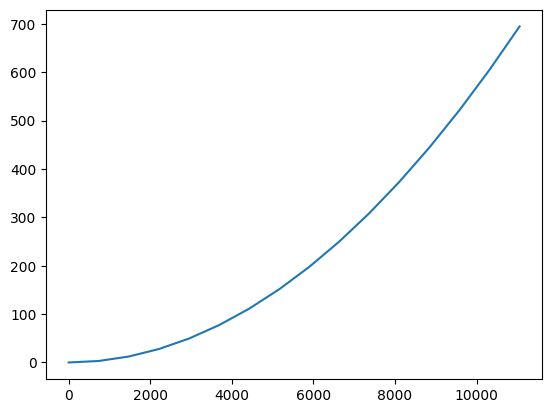

In [94]:
plt.plot(x0, z0)
plt.show()

In [95]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [96]:
init=1
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [97]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [98]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [99]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)

In [100]:
def static_func(Q): # It is not working properly for non zero roll, pitch and yaw; serves our needs though
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    
    Z0= - np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 

    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################ 
    
    
    
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    
    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=scipy.linalg.lstsq(A[i],B[i], check_finite=True)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [101]:
q0

array([0.00000000e+00, 7.36845656e+02, 1.47369131e+03, 2.21053697e+03,
       2.94738263e+03, 3.68422828e+03, 4.42107394e+03, 5.15791959e+03,
       5.89476525e+03, 6.63161091e+03, 7.36845656e+03, 8.10530222e+03,
       8.84214788e+03, 9.57899353e+03, 1.03158392e+04, 1.10526848e+04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root = fsolve(static_func, q0)

/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_46748/701681181.py:1: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  root = fsolve(static_func, q0)


In [103]:
root

array([0.00000000e+00, 7.36845656e+02, 1.47369131e+03, 2.21053697e+03,
       2.94738263e+03, 3.68422828e+03, 4.42107394e+03, 5.15791959e+03,
       5.89476525e+03, 6.63161091e+03, 7.36845656e+03, 8.10530222e+03,
       8.84214788e+03, 9.57899353e+03, 1.03158392e+04, 1.10526848e+04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [104]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [105]:
q0=root

In [106]:
q0

array([0.00000000e+00, 7.36845656e+02, 1.47369131e+03, 2.21053697e+03,
       2.94738263e+03, 3.68422828e+03, 4.42107394e+03, 5.15791959e+03,
       5.89476525e+03, 6.63161091e+03, 7.36845656e+03, 8.10530222e+03,
       8.84214788e+03, 9.57899353e+03, 1.03158392e+04, 1.10526848e+04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

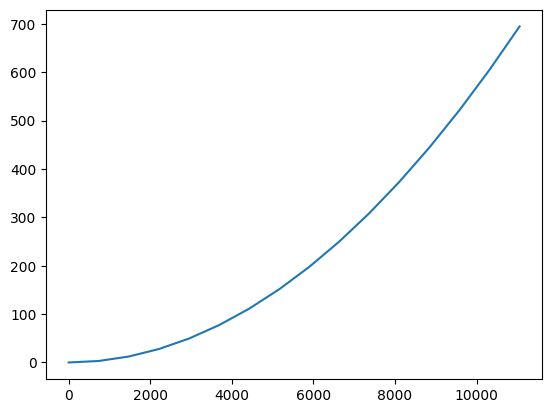

In [107]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [108]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [109]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L
    
    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3], 
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])  
    
    
    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])
        
        
    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1), 
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)           

In [110]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]    
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]
    
    return K

In [111]:
def FEA_u(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e9, G=84e9, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):
    coord=np.array(coord)
    elcon=np.array(elcon)
    
    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))
    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
    
    glob_force = np.dot(K,np.array(vessel_movement))
    
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    F=np.zeros(len(coord)*6) 
    
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]
#     print(F,'F')
#     print(F)
    
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m
    
    bc=np.array([bc_node, 
                bc_val]).T.astype(np.float64)
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0] 
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    
#     Q=np.dot(K,d).T-F 
    return d, np.dot(K,d).T

In [112]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)), 
        bc_val=[0]*18,
        vessel_movement=[-0.0705e-4,-0.0007e-4,0.1418e-4,0.0145e-4,0.0175e-4,0.0114e-4,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0],
        coefs=[1,1,1,1,1,1])

In [113]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00])

In [114]:
f

array([-9.99786375e+03, -3.59333333e+00,  2.00042617e+04,  5.25000000e-02,
        1.75000000e-02,  3.18500000e-01,  9.87000000e+03, -3.06133333e+01,
       -1.07846667e+02, -2.03000000e+00, -1.74020000e+02,  2.99600000e+01,
        9.03000000e+01, -3.92933333e+01, -1.98520000e+04,  3.86400000e+01,
        1.23200000e+02, -1.59600000e+00,  3.75637500e+01,  7.35000000e+01,
       -4.44150000e+01, -9.64425000e+01, -1.83750000e+00, -8.70975000e+01])

In [115]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e9, G=84e9, A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2):
    coord=np.stack((X,Y,Z)).T 
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])
        
    bc_node=list(range(6))
    bc_val=[0]*6
    
    vessel_move=np.zeros(len(X)*6)
    vessel_move[-6:]=vessel_movement
#     print (vessel_move)
    d,f=FEA_u(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)
#     print('d',d)
    
    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])
        
    mom =[]   
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])
        
    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3]) 
    return np.array(fors), np.array(mom), np.array(angle)

In [116]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02, 
 0.03, 
 0.01, 
 -0.05, 
 0.03],
 [1,1,1,1,1,1]
)

In [117]:
fors

array([[-3.07941749e+05,  3.27696483e+02, -3.68699915e+04],
       [-6.17980957e-04,  2.03877550e-03,  3.45706940e-04],
       [-8.54492188e-04,  1.47266458e-03, -2.57015228e-03],
       [-4.80651855e-03, -1.02318806e-03, -1.04594231e-03],
       [ 0.00000000e+00,  1.99707912e-03,  1.64031982e-04],
       [ 0.00000000e+00,  6.20801235e-04, -3.50952148e-04],
       [-2.44140625e-03, -1.06944604e-03,  3.66210938e-04],
       [ 2.68554688e-03, -7.99449765e-04, -4.39453125e-03],
       [ 3.90625000e-03,  4.78020404e-04,  5.18798828e-04],
       [-1.95312500e-03, -1.20275002e-03,  1.22070312e-04],
       [-1.95312500e-03,  8.19039298e-04,  0.00000000e+00],
       [ 1.95312500e-03,  6.20502215e-05,  3.66210938e-04],
       [-9.76562500e-04,  6.69807196e-05, -3.66210938e-04],
       [ 0.00000000e+00,  7.08047301e-05,  0.00000000e+00],
       [ 3.90625000e-03,  7.05802813e-05,  0.00000000e+00],
       [ 3.07941754e+05, -3.27700085e+02,  3.68699988e+04]])

### Vessle Simulation

In [118]:
sampleTime = 0.001              # sample time [seconds]
N = 50000                      # number of samples

In [119]:
N*sampleTime

50.0

In [120]:
vehicle=semisub('DPcontrol',2,-1,40.0,0,0) 

In [121]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [122]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

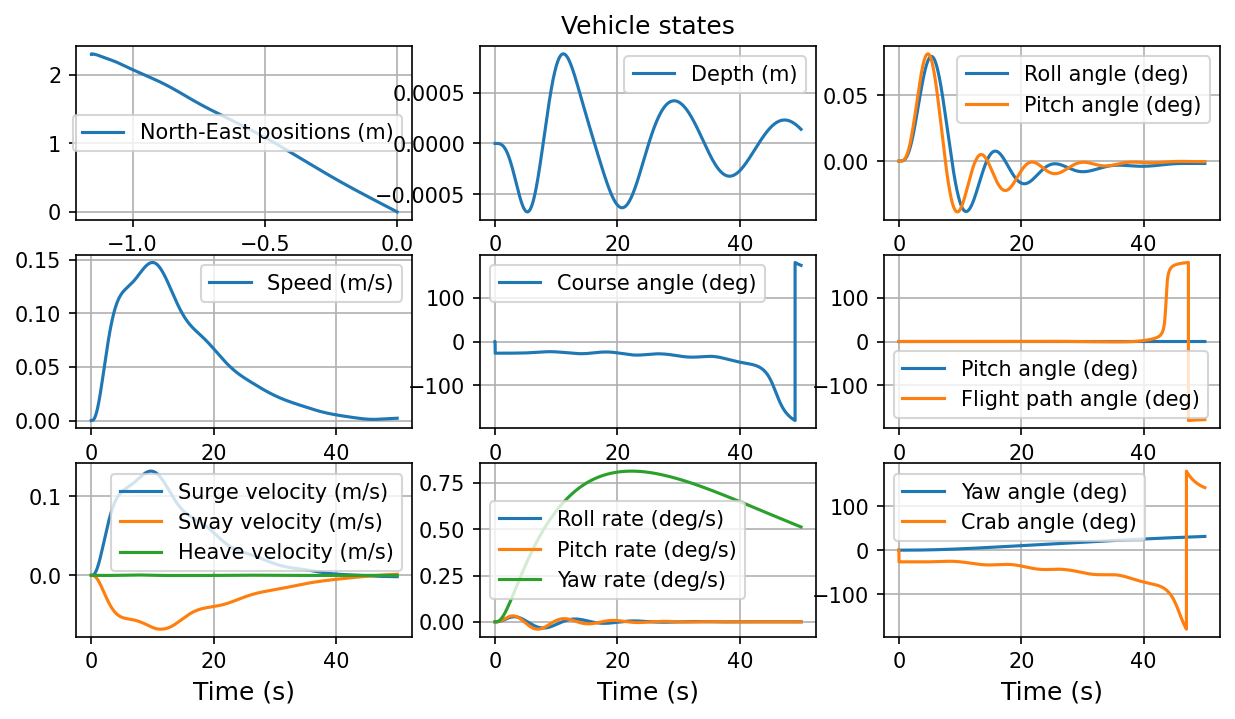

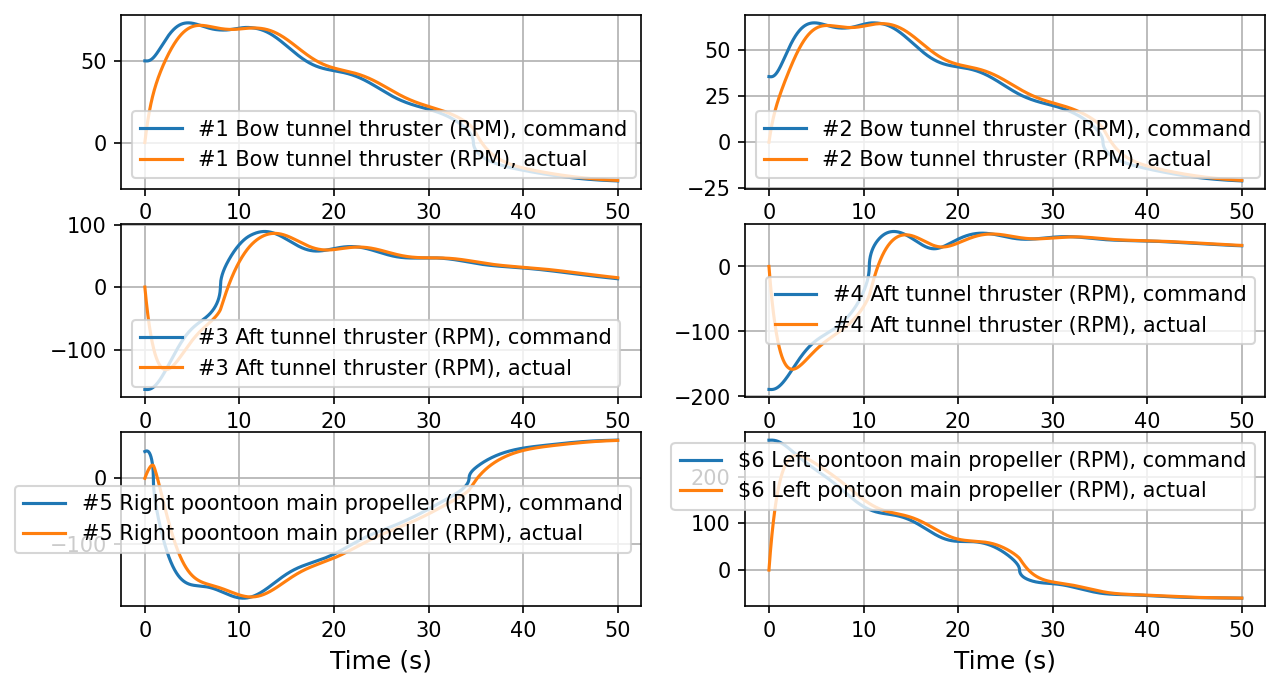

In [123]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [124]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

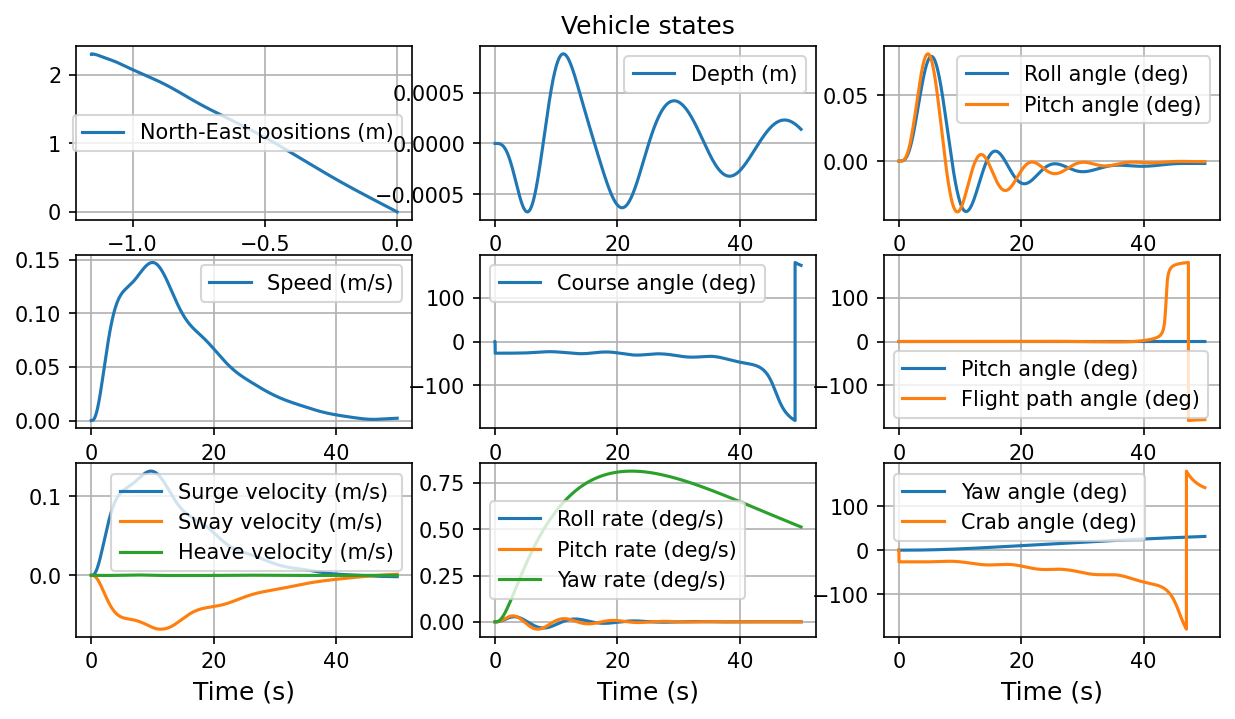

In [125]:
plotVehicleStates(simTime, simData, 3)

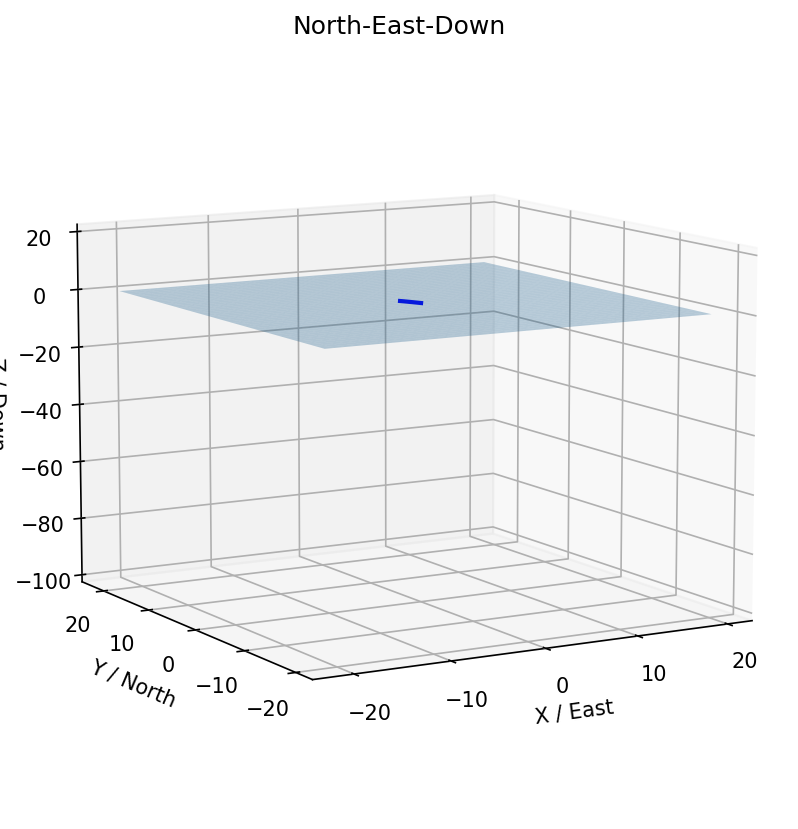

In [126]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [127]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [128]:
idx=1/0.01

In [129]:
idx

100.0

In [130]:
ssa(simData[:, 3][int(idx)])

4.347863402642815e-09

In [131]:
ssa(simData[:, 4][int(idx)])

5.966248384225992e-09

In [132]:
ssa(simData[:, 5][int(idx)])

1.3685324873335958e-08

In [133]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [134]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

### Dynamics

In [135]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(100)]
        self.wall_clock = datetime.now()

In [136]:
def grayscott1d(t, Q, coefs, T): 
#     print(t,T.my_t,t-T.my_t)
#     print(t)
#     if (t-T.my_t)!=0 and abs(t-T.my_t)<1e-10:
#         return 'error'
     
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
   
    
    
#     u_ve = simData[:, 6][idx]
#     v_ve = simData[:, 7][idx]
#     w_ve = simData[:, 8][idx]
#     p_ve = simData[:, 9][idx]
#     q_ve = simData[:, 10][idx]
#     r_ve = simData[:, 11][idx]
    
    
#     η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
#     dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_[2])
  
    
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

#     φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
#     φ=ssa(φ)
#     θ=ssa(θ)
#     ψ=ssa(ψ)
#     Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    
    vessel_movement = np.zeros(6).astype(np.float64)
    vessel_movement[0] = x_ve-T.v_m[0]
#     vessel_movement[1] = y_ve-T.v_m[1]
#     vessel_movement[2] = z_ve-T.v_m[2]
    vessel_movement[1] = z_ve-T.v_m[1]
    vessel_movement[2] = y_ve-T.v_m[2]
    
#     vessel_movement[3] = phi_ve-T.v_m[3]
#     vessel_movement[4] = theta_ve-T.v_m[4]

    
    vessel_movement[3] = theta_ve-T.v_m[3]
    vessel_movement[4] = phi_ve-T.v_m[4]
    vessel_movement[5] = psi_v-T.v_m[5]
    
    
#     print(vessel_movement)
    
#     if t-T.my_t > 0.001: 
    T.v_m[0] = x_ve
#     T.v_m[1] = y_ve
#     T.v_m[2] = z_ve
    T.v_m[1] = z_ve
    T.v_m[2] = y_ve
#     T.v_m[3] = phi_ve
#     T.v_m[4] = theta_ve

    T.v_m[3] = theta_ve
    T.v_m[4] = phi_ve
    T.v_m[5] = psi_v
#     else:
#         T.v_m[0] = 0.001
#         T.v_m[1] = 0
#         T.v_m[2] = 0
#         T.v_m[3] = 0
#         T.v_m[4] = 0
#         T.v_m[5] = 0
    
#     print(vessel_movement )
#     print(T.v_m,"l")
    
    
#     print(vessel_movement)
    fors, mom, angle = PipeForce(x, y, z, vessel_movement, coefs)
#     vessel_movement0=vessel_movement
#     print(fors.astype(np.float64))
    
    φ,θ,ψ=angle.T
    Ret = Re_t(φ,θ,ψ)

    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()
#     print(fors)

    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T

  
    Z= (
        Z1
        + Z2 
        +Z0
       )

############################################################    
    RRRR=Re_b(Ret)

    
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T

    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################      
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
    
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))

    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)
 
    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################
    T.my_t=t
    
    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()
        
#     T.v_m=np.copy(vessel_movement)
  
    return np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

In [137]:
tspan = (0., 20)
T_ = MyTime()

In [138]:
coefs = [1, 1, 1, 1, 1, 1]

In [139]:
startTime1 = datetime.now()
us=solve_ivp(grayscott1d,  
             tspan, 
             q0,
#             method='LSODA',
#              t_eval=[i*sampleTime/10 for i in range(int(tspan[-1]/(sampleTime/10)))],
#              atol=1e-2,
             args=(coefs,T_,))
print(datetime.now() - startTime1)

Physical time:  0.33736092074315976  Iteration wall clock time:  0:00:00.035900
Physical time:  1.0000625545565403  Iteration wall clock time:  0:13:36.183685
Physical time:  2.000655587311185  Iteration wall clock time:  0:26:03.722991
Physical time:  3.000480453671248  Iteration wall clock time:  0:29:53.928259
Physical time:  4.000256804100611  Iteration wall clock time:  0:39:38.656482
Physical time:  5.000384546611797  Iteration wall clock time:  0:35:54.692199
Physical time:  6.0001736788174345  Iteration wall clock time:  0:38:03.322337
Physical time:  7.003034708578968  Iteration wall clock time:  0:34:49.536040
Physical time:  8.000196081099638  Iteration wall clock time:  0:30:55.935894
Physical time:  9.001510545806422  Iteration wall clock time:  0:28:02.260751
Physical time:  10.000466479442016  Iteration wall clock time:  0:23:35.327348
Physical time:  11.001265563641402  Iteration wall clock time:  0:21:03.191704
Physical time:  12.000540187044082  Iteration wall clock t

### Results

In [140]:
fin=us

In [141]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.214e-04 ...  2.000e+01  2.000e+01]
        y: [[ 0.000e+00  0.000e+00 ...  5.339e-05  5.339e-05]
            [ 7.368e+02  7.368e+02 ...  2.556e+02  2.555e+02]
            ...
            [ 0.000e+00  0.000e+00 ...  1.746e-01  1.746e-01]
            [ 0.000e+00  0.000e+00 ...  2.083e-01  2.083e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1972868
     njev: 0
      nlu: 0

In [142]:
t=fin.t

In [143]:
fin=fin.y.T

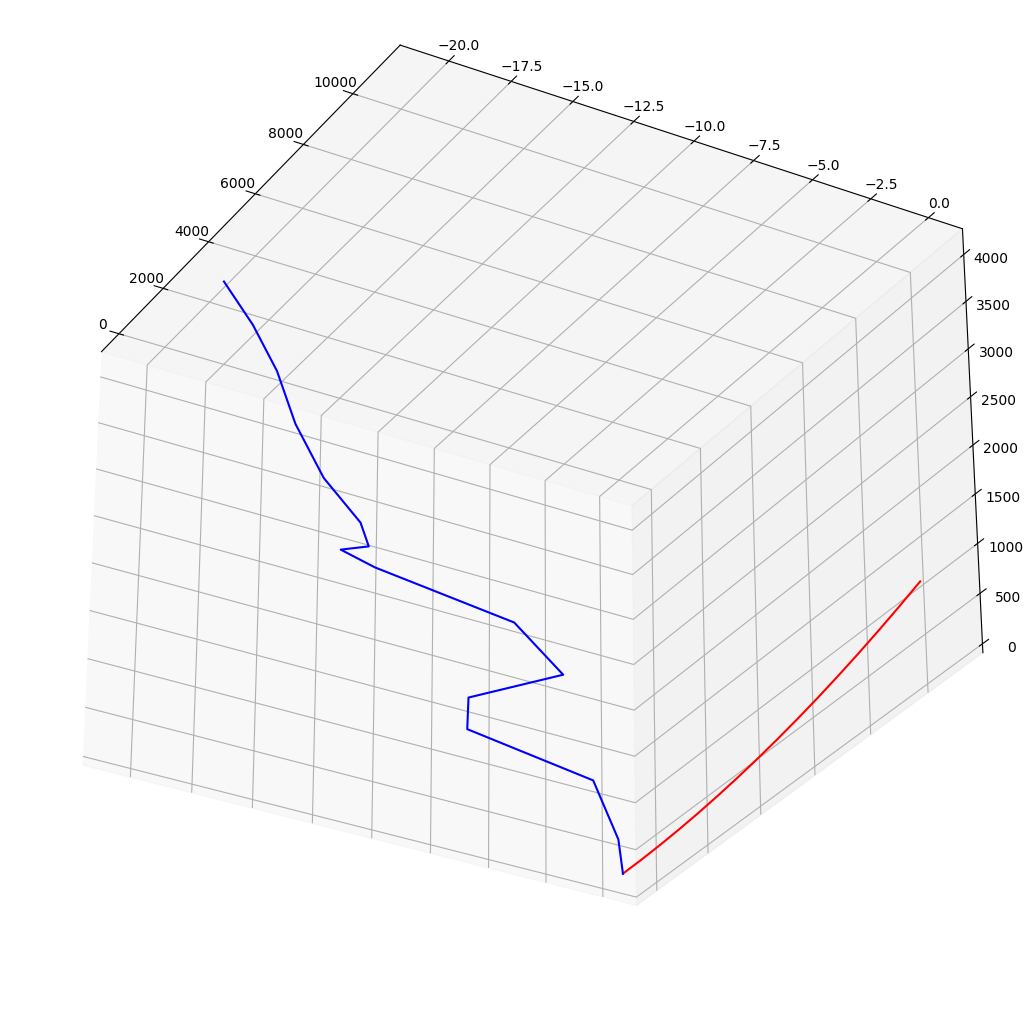

In [144]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
ax.view_init(-30,-30)
# ax.view_init(0,-90)
plt.show()

In [145]:
X,Y,Z

(array([5.33899485e-05, 2.55548918e+02, 8.04741023e+02, 7.23230133e+02,
        4.82104069e+02, 8.29558437e+02, 1.17125711e+03, 1.15606142e+03,
        1.24686182e+03, 1.49817278e+03, 1.76354103e+03, 1.97850016e+03,
        2.17169483e+03, 2.42694399e+03, 2.75307484e+03, 3.10990282e+03]),
 array([-6.07438867e-08, -4.72928724e-01, -2.16940229e+00, -7.54146842e+00,
        -7.24488430e+00, -3.48903196e+00, -5.99856277e+00, -1.19921925e+01,
        -1.35377037e+01, -1.26029392e+01, -1.32302765e+01, -1.50199489e+01,
        -1.64401835e+01, -1.75068058e+01, -1.88660234e+01, -2.04411623e+01]),
 array([-8.08515231e-03,  2.78692950e+02,  6.81550075e+02,  8.91431032e+02,
         1.29302297e+03,  1.70992185e+03,  2.02631935e+03,  2.20604027e+03,
         2.26647778e+03,  2.30997742e+03,  2.45902306e+03,  2.75730387e+03,
         3.18775170e+03,  3.61644918e+03,  3.93183115e+03,  4.18940174e+03]))

In [146]:
X0,Y0,Z0

(array([    0.        ,   736.8456563 ,  1473.69131259,  2210.53696889,
         2947.38262519,  3684.22828149,  4421.07393778,  5157.91959408,
         5894.76525038,  6631.61090668,  7368.45656297,  8105.30221927,
         8842.14787557,  9578.99353187, 10315.83918816, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([  0.        ,   3.08229036,  12.32937719,  27.7419077 ,
         49.32096066,  77.06804645, 110.98510714, 151.07451669,
        197.33908104, 249.78203837, 308.4070593 , 373.21824713,
        444.22013816, 521.417702  , 604.81634189, 694.42189511]))

In [147]:
us=fin.T

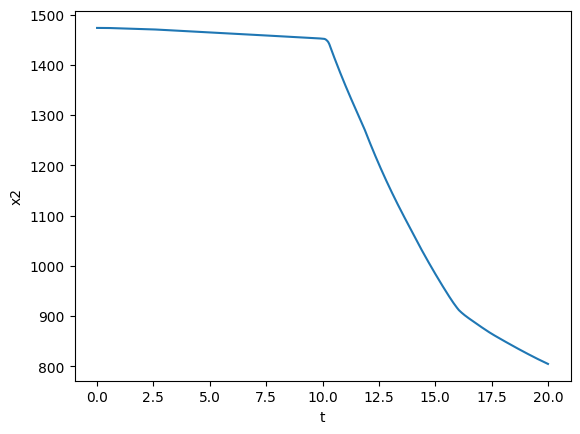

In [148]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

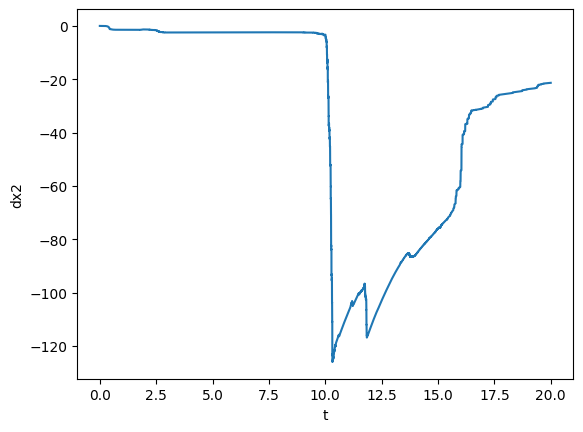

In [149]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

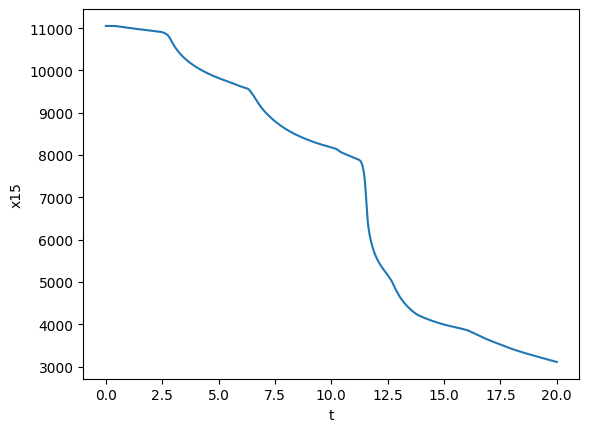

In [150]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x15')
plt.show()

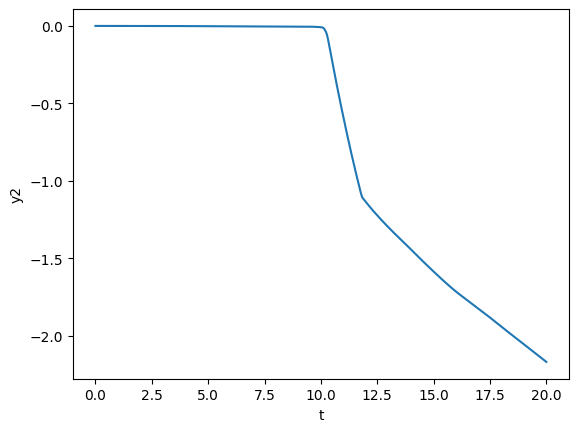

In [151]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

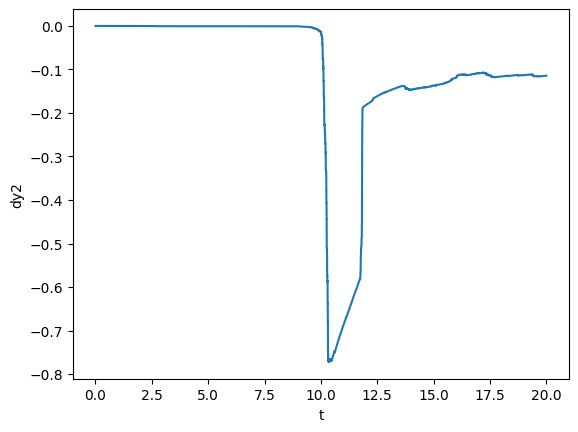

In [152]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

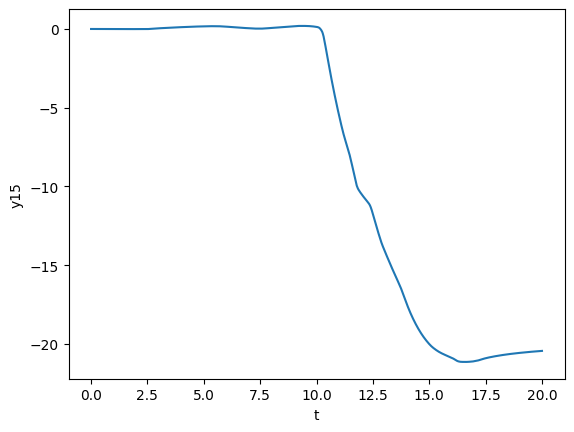

In [153]:
plt.plot(t,us.T[:,2*node_N+15] ,'-')
plt.xlabel('t')
plt.ylabel('y15')
plt.show()

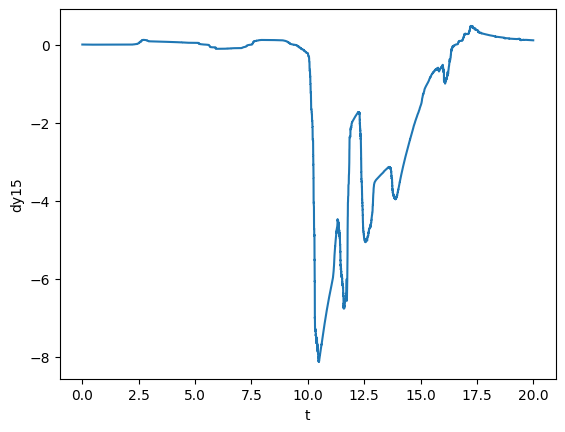

In [154]:
plt.plot(t,us.T[:,3*node_N+15] ,'-')
plt.xlabel('t')
plt.ylabel('dy15')
plt.show()

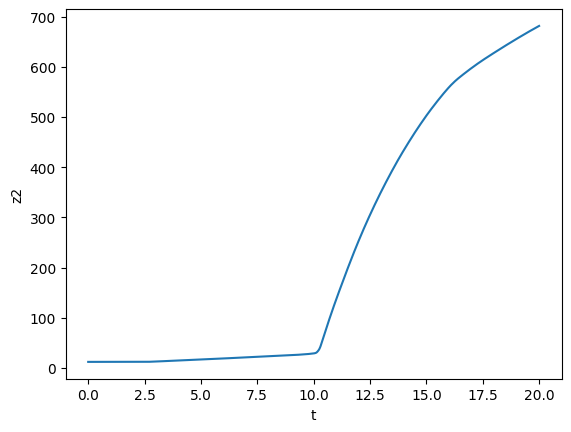

In [155]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

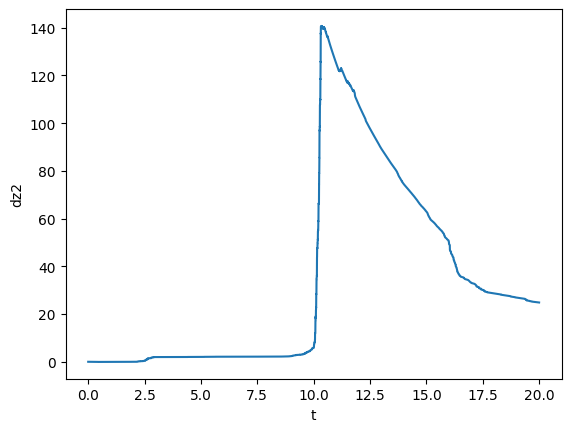

In [156]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

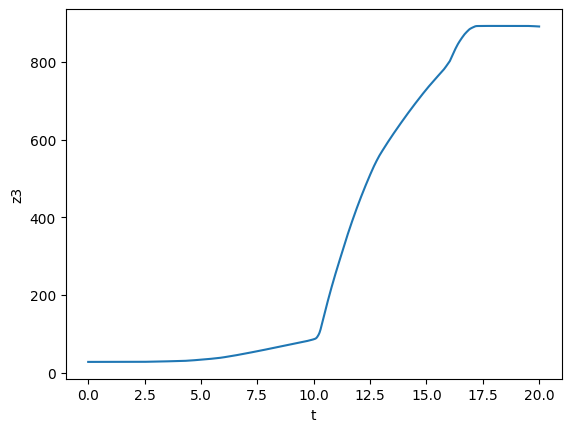

In [157]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

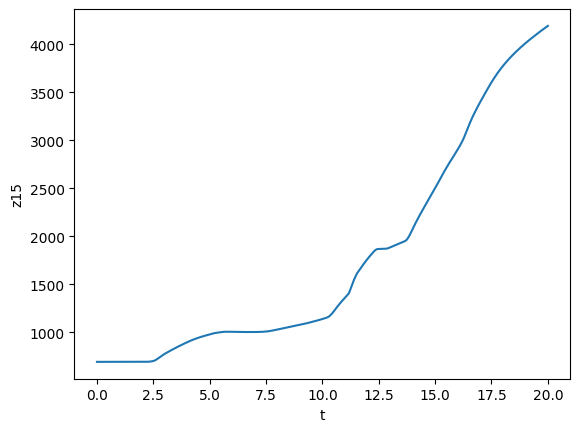

In [158]:
plt.plot(t,us.T[:,4*node_N+15] ,'-')
plt.xlabel('t')
plt.ylabel('z15')
plt.show()

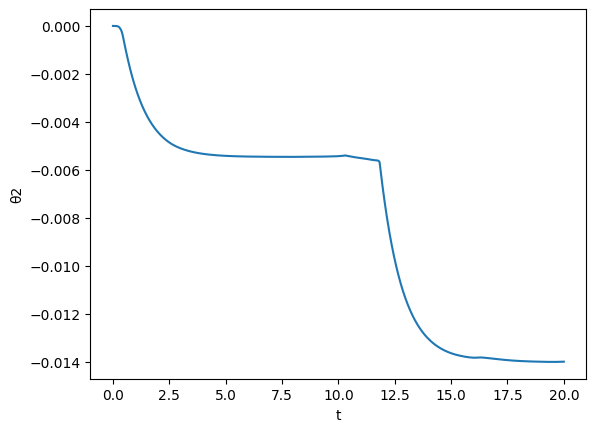

In [159]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

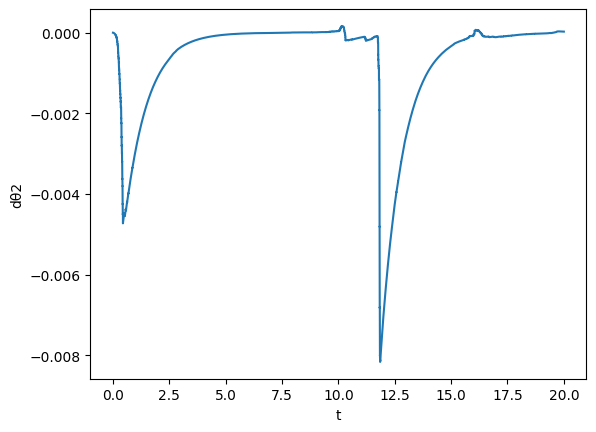

In [160]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

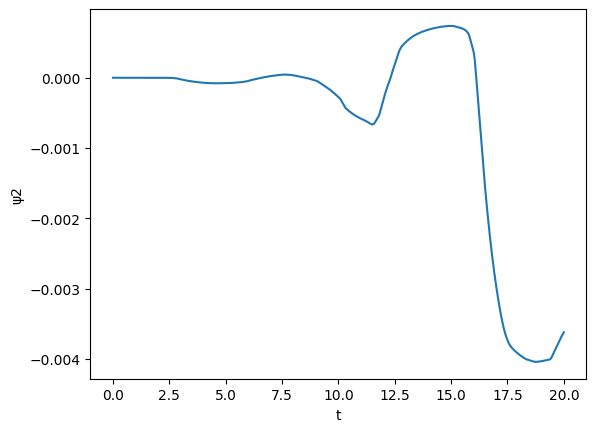

In [161]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

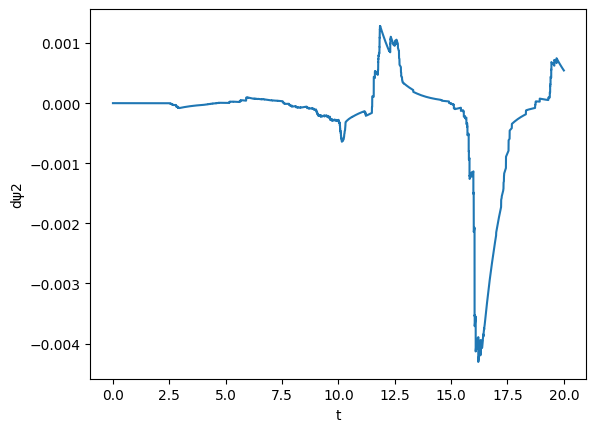

In [162]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()